# 1.kütüphane tanımlama

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2.Drive Bağlanma

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dosya_yolu = '/content/drive/MyDrive/duygu_analizi.csv'


In [4]:

# 3. CSV Dosyasını Okuma ve Kodlama Hatalarını Çözme
try:
    # 1. Deneme: UTF-8 ve varsayılan (,) ayırıcı
    df = pd.read_csv(dosya_yolu, encoding='utf-8')
    print(" Dosya başarıyla yüklendi (UTF-8).")

except UnicodeDecodeError:
    try:
        # 2. Deneme: Latin-1 ve noktalı virgül (;) ayırıcısı
        df = pd.read_csv(dosya_yolu, encoding='latin-1', sep=';')
        print(" Dosya başarıyla yüklendi (Latin-1 ve ; ayırıcı).")
    except Exception:
        try:
            # 3. Deneme: UTF-16 ve Virgül (,) ayırıcısı
            df = pd.read_csv(dosya_yolu, encoding='utf-16', sep=',')
            print(" Dosya başarıyla yüklendi (UTF-16 ve , ayırıcı).")
        except Exception as e:
            print(f" TÜM KODLAMA DENEMELERİ BAŞARISIZ OLDU. Hata: {e}")
            raise # Hata oluşursa durur

# 4. Sütun Adlarını Temizleme ve Standartlaştırma
# Bu, büyük/küçük harf ve gizli boşluk hatalarını önler.
df.columns = df.columns.str.strip().str.lower()
print("\n✅ Sütun adları temizlendi ve küçük harfe çevrildi.")
print("Temizlenmiş Sütunlar:", df.columns.tolist())

# 5. Sütunları Tanımlama (Standart formatta)
TEXT_COLUMN = 'görüş'
LABEL_COLUMN = 'durum'

# 6. Sadece İhtiyaç Duyulan Sütunları Seçme
try:
    df = df[[TEXT_COLUMN, LABEL_COLUMN]].copy()
    print(" 'görüş' ve 'durum' sütunları başarıyla seçildi.")

except KeyError:
    print(f"\n HATA: '{TEXT_COLUMN}' veya '{LABEL_COLUMN}' sütunları bulunamadı.")
    print("Lütfen yukarıdaki Temizlenmiş Sütunlar listesine göre kodunuzu düzeltin.")
    raise

 Dosya başarıyla yüklendi (UTF-16 ve , ayırıcı).

✅ Sütun adları temizlendi ve küçük harfe çevrildi.
Temizlenmiş Sütunlar: ['görüş', 'durum']
 'görüş' ve 'durum' sütunları başarıyla seçildi.


 # 3.veri yükleme ve hazırlık

In [5]:
TEXT_COLUMN = 'görüş'
LABEL_COLUMN = 'durum'
# 1.Etiketleri sayısal hale getirme(0,1,2)
label_mapping={
    'olumsuz':0,
    'Tarafsız':1,
    'Olumlu':2
}
df[LABEL_COLUMN]=df[LABEL_COLUMN].map(label_mapping)
print("Etiketler sayısal hale getirildi.")
# metin temizleme
import re
def metin_temizle(metin):
  metin=metin.lower()
  metin=re.sub(r'[^a-zA-ZçÇğĞıİöÖşŞüÜ\s]','',metin)
  metin=re.sub(r'\s+',' ',metin).strip()
  return metin
  df[TEXT_COLUMN]=df[TEXT_COLUMN].apply(metin_temizle)


Etiketler sayısal hale getirildi.


# 4. Metin ön işleme ve Vektörleşme

In [6]:
import nltk
nltk.download('stopwords'
)
print("yüklendi.")

yüklendi.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
print(f"silinmeden önceki satır sayısı:{len(df)}")
df.dropna(subset=['görüş'],inplace=True)
print(f"görüş eksikleri silindi.Kalan satır sayısı:{len(df)}")

silinmeden önceki satır sayısı:11429
görüş eksikleri silindi.Kalan satır sayısı:11426


In [8]:
df.dropna(subset=['durum'],inplace=True)
print(f"durum eksikleri silindi.Kalan satır sayısı:{len(df)}")

durum eksikleri silindi.Kalan satır sayısı:7189


In [9]:
import numpy as np
df['görüş']=df['görüş'].replace(np.nan,'')
df['görüş']=df['görüş'].astype(str)
print("string formatına dönüştürüldü")
print(f"veri tipi kontrolü:",df['görüş'].dtype)

string formatına dönüştürüldü
veri tipi kontrolü: object


In [10]:
import nltk
from nltk.corpus import stopwords
turkce_stopwords=stopwords.words('turkish')
def stop_word_cikor(metin):
  kelimeler=metin.split()
  filtrelenmis_kelimeler=[k for k in kelimeler if k not in turkce_stopwords]
  return ' '.join(filtrelenmis_kelimeler)
df['görüş_temiz_son']=df['görüş'].apply(stop_word_cikor)


In [11]:
print(df.columns)
print(df[['görüş','görüş_temiz_son']].head())

Index(['görüş', 'durum', 'görüş_temiz_son'], dtype='object')
                                               görüş  \
1                         hizli teslimat tesekkürler   
2  ses olayı süper....gece çalıştır sıkıntı yok.....   
5  Giriş seviyesindeki kullanıcılar için kabul ed...   
6                                    kullanisli baya   
7  Dezavantajlar : Pahalı ürün<br />Merhabalar bu...   

                                     görüş_temiz_son  
1                         hizli teslimat tesekkürler  
2  ses olayı süper....gece çalıştır sıkıntı yok.....  
5  Giriş seviyesindeki kullanıcılar kabul edilebi...  
6                                    kullanisli baya  
7  Dezavantajlar : Pahalı ürün<br />Merhabalar le...  


# 5. Vektörleşme(özellik çıkarımı)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# 1.x(özellikler) ve y(etiketler) ayrımı
X=df['görüş_temiz_son']
y=df['durum']
# test olarak bölme(%80 eğitim ,%20 test)
X_train_text,X_test_text,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
#metinleri sayısal vektörlere dönüştürme
vectorizer=TfidfVectorizer(max_features=5000,ngram_range=(1,2)) # en sık kullanılan 500 kelime
#eğitim verisi üzerinden öğrenme
X_train=vectorizer.fit_transform(X_train_text)
# test verisini ,eğitimden öğrenme
X_test=vectorizer.transform(X_test_text)
print("vektörleştirme ve eğitim/test ayrımı tamamlandı."
)
print(f"eğitim verisi boyutu:{X_train.shape}")


vektörleştirme ve eğitim/test ayrımı tamamlandı.
eğitim verisi boyutu:(5751, 5000)


# 6.Model Eğitimi

In [13]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
print("model eğitimi tamamlandı.")

model eğitimi tamamlandı.


# 7.Tahmin Yapma ve Değerlendirme


---model performans raporu
              precision    recall  f1-score   support

         1.0       0.78      0.72      0.75       587
         2.0       0.81      0.86      0.84       851

    accuracy                           0.80      1438
   macro avg       0.80      0.79      0.79      1438
weighted avg       0.80      0.80      0.80      1438


---karmaşıklık matrisi
[[420 167]
 [118 733]]


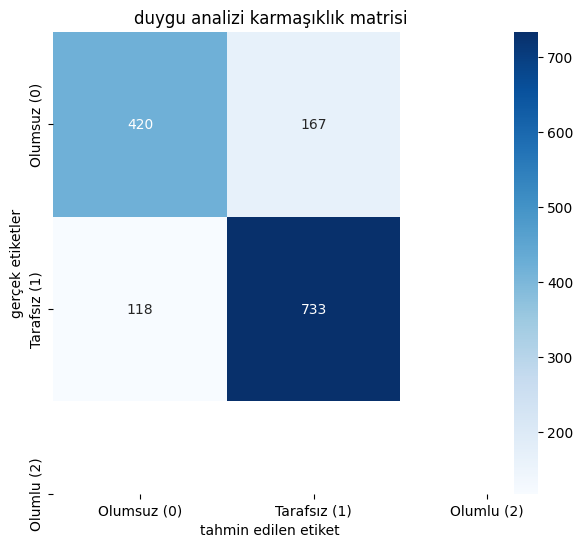

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# test verileri üzerinde tahmin yapma
y_pred=model.predict(X_test)
# model performans raporu
print("\n---model performans raporu")
print(classification_report(y_test,y_pred))
#karmaşıklık matrisi
print("\n---karmaşıklık matrisi")
cm=confusion_matrix(y_test,y_pred)
print(cm)
#matrisi görselleştirme
plt.figure(figsize=(7,6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',xticklabels=['Olumsuz (0)', 'Tarafsız (1)', 'Olumlu (2)'] ,
    yticklabels=['Olumsuz (0)', 'Tarafsız (1)', 'Olumlu (2)'])
plt.title('duygu analizi karmaşıklık matrisi'
)
plt.ylabel('gerçek etiketler'
)
plt.xlabel('tahmin edilen etiket')
plt.show()